In [36]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import export_graphviz
from sklearn.model_selection import RandomizedSearchCV
from IPython.display import Image
import graphviz

In [37]:
# Load the datasets
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Explore the training data
print(train_data.head())
print(train_data.info())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
<c

In [38]:
# Feature engineering
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1
test_data['FamilySize'] = test_data['SibSp'] + test_data['Parch'] + 1

In [39]:
# Handle missing values
train_data['Age'].fillna(train_data['Age'].median(), inplace=True)
test_data['Age'].fillna(test_data['Age'].median(), inplace=True)
train_data['Embarked'].fillna(train_data['Embarked'].mode()[0], inplace=True)
test_data['Fare'].fillna(test_data['Fare'].median(), inplace=True)

In [40]:
# Encode categorical features
label_encoder = LabelEncoder()
train_data['Sex'] = label_encoder.fit_transform(train_data['Sex'])
test_data['Sex'] = label_encoder.transform(test_data['Sex'])
train_data['Embarked'] = label_encoder.fit_transform(train_data['Embarked'])
test_data['Embarked'] = label_encoder.transform(test_data['Embarked'])

In [41]:
# Select features and target variable
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize']
X = train_data[features]
y = train_data['Survived']

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model (Decision Tree Classifier)
rf_model = RandomForestClassifier(random_state=42)

In [42]:
# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': range(50, 500),
    'max_depth': range(1, 20)
}

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf_model, 
                                 param_distributions=param_dist, 
                                 n_iter=5, 
                                 cv=5, 
                                 random_state=42)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = rand_search.best_params_

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'n_estimators': 490, 'max_depth': 12}


In [43]:
# Assess model performance on the validation set
best_rf_model = rand_search.best_estimator_
predictions = best_rf_model.predict(X_valid)

# Evaluate the model
accuracy = accuracy_score(y_valid, predictions)
conf_matrix = confusion_matrix(y_valid, predictions)
class_report = classification_report(y_valid, predictions)

# Print the results
print("Best Hyperparameters:", best_params)
print("\nAccuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

Best Hyperparameters: {'n_estimators': 490, 'max_depth': 12}

Accuracy: 0.8212290502793296

Confusion Matrix:
 [[91 14]
 [18 56]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85       105
           1       0.80      0.76      0.78        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



In [44]:
# Choose one of the decision trees from the forest (e.g., the first tree)
tree_to_visualize = best_rf_model.estimators_[0]

# Visualize the chosen decision tree
dot_data = export_graphviz(
    tree_to_visualize,
    feature_names=features,
    class_names=['Not Survived', 'Survived'],
    filled=True,
    rounded=True,
    special_characters=True
)

graph = graphviz.Source(dot_data)
graph.render('random_forest_decision_tree', format='png')
graph.view('random_forest_decision_tree')

'random_forest_decision_tree.pdf'

In [45]:
# Make predictions on the test set
test_features = test_data[features]
test_predictions = best_rf_model.predict(test_features)

In [46]:
# Prepare the submission DataFrame
submission_df = pd.DataFrame({'PassengerId': test_data['PassengerId'], 'Survived': test_predictions})

# Save the submission DataFrame to CSV file
submission_df.to_csv('titanic_submission.csv', index=False)

# Save the submission DataFrame to Excel file
submission_df.to_excel('titanic_submission.xlsx', index=False)

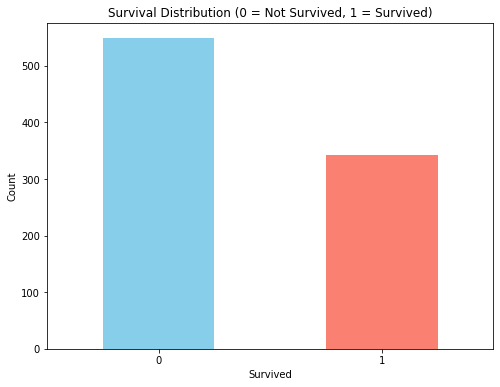

In [47]:
# Count the number of survivors
survived_counts = train_data['Survived'].value_counts()

# Plot a bar chart
plt.figure(figsize=(8, 6))
survived_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Survival Distribution (0 = Not Survived, 1 = Survived)')
plt.xlabel('Survived')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()